## Title: " Exploring landslide severity across Washington using machine learning techniques"
### Erich Seamon
### erichs@uidaho.edu
### http://webpages.uidaho.edu/erichs


# Introduction and Overview of Dataset


The premise of this research will be to develop a set of models that effectively predict landslide severity, within the state of Washington, using geomorphic and landscape-driven feature variables, such as geology, soils, gradient, land-use, and previous landslide type.   <br>

Previous work by Ardizzone et al (2002), Ayalew and Yamagishi (2005), Ohlmacher and David (2003), all used logistical regression as a classifer method for landslide analysis. To expand upon this work, this project will evaluate several differing models to predict landslide severity:<br>

- logistical regression <br> 
- naive bayes <br>
- knn <br>
- random forest <br>
- decision tree <br>
- bagged decision tree <br>
- bagged random forest <br>


Under this approach, landslide explanatory variables will be trained on a training data set of an observed landslide locations, with thematic data such as morphometric attributes (gradient, slope morphology) as well as information on geology and landuse. 

The eventual goal will be to create a landslide model that is capable of returning a predictive result in the form of a geographic mapspace (essentially a prediction for each pixel).

## Data Sources

2007 and 2008 Landslide data for the state of Washington, containing over 52,000 observations, was accessed from the Washington Department of Natural Recreation (WA DNR). The data was provided as a downloadable .gdb file (geodatabase file).

http://www.dnr.wa.gov/publications/ger_portal_landslides_landforms.zip


## Data Transformation Before Analysis

The data was imported as a csv file - that was derived from the provided geodatabase file.  This csv file contained over 52,000 observations, with latitude and longitude included as well.  The csv file was transformed into a a pandas data frame, with text based categorical fields transformed to numeric values.  From this pandas data frame, our feature columns (X) and our response variable (y) were derived.

From the 52,000+ landslide observations, the number was reduced to:

#### 12,241

After eliminating records with NANs and other missing values needed for the analysis.

In [1]:
import PIL
from scipy import stats
import os,sys
import numpy as np
from PIL import Image
from urllib2 import urlopen

## Response and Feature Variables:

### Morphometric feature variables:

1) Slope Morphology Shape (SLOPE_MORP)   - Planar, Convex, Concave, etc. <br>
2) Land Use (LAND_USE)   - Forestry, Road/Rail/Trail, Undistubed, Urban Development <br>
3) Landslide Type (LANDSLIDE1)   - Debris Flows, Debris Slides and Avalanches, Shallow Undifferentiated, etc.<br>
4) Gradient (GRADIENT_D - transformed to gradient_cat)  - gradient of the landslide location, in degrees.<br>
5) Geology (GEOLOGIC_1) - geologic unit <br>
6) Soils (reacch_soi) - soils <br>

### Response Variable:

1) Landslide Severity (LANDSLID_3) - Low (0), Med (1) or High (2). <br>

Multiclass classification means a classification task with more than two classes. Multiclass classification makes the assumption that each sample is assigned to one and only one label.

# Preliminary Data Import and Analysis

In [3]:
import matplotlib
%matplotlib nbagg

from pyproj import Proj
import StringIO
from pandas import DataFrame
import pandas as pd
import seaborn as sns
import pydot
from IPython.display import Image

from urllib2 import Request, urlopen
import json
from pandas.io.json import json_normalize
import numpy
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
%load_ext memory_profiler
from sklearn.ensemble import RandomForestClassifier

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


## Import csv file for all 52,000+WA landslides

In [4]:
import csv

In [6]:
walandslides_all = pd.read_csv('http://dmine.io/data/landslides/WALandslides_export4.csv')

In [10]:
walandslides = pd.read_csv('http://dmine.io/data/landslides/WALandslides.csv')

/usr/local/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (11,12,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


## Table of all values for initial landslide dataset

In [11]:
walandslides_allxy = [walandslides_all.OBJECTID, walandslides_all.POINT_X, walandslides_all.POINT_Y]
walandslides_allxy = pd.DataFrame(walandslides_allxy)
walandslides_allxy = walandslides_allxy.transpose()
walandslides = pd.DataFrame(walandslides)
walandslides = pd.merge(walandslides_allxy, walandslides, on='OBJECTID', how='outer')

## Set landslide type as numeric

In [12]:
stringh1 = set(walandslides.LANDSLIDE1)
J = list(stringh1)
J2 = list(range(1, 106))

In [13]:
i2 = iter(J)
j2 = iter(J2)
k2 = list(zip(i2, j2))
kdict2 = dict(k2)
kdict2.values()
walandslides['LANDSLIDE1'].replace(kdict2, inplace=True)
#print walandslides.LANDSLIDE1

## Convert categorical text columns to categorical numerical

In [14]:
walandslides['DATA_CONFI'] = walandslides.DATA_CONFI.map({'Low':0, 'Moderate-High':1})
walandslides['SLOPE_MORP'] = walandslides.SLOPE_MORP.map({'Planar':0, 'Concave-Planar':1, 'Concave, convergent':2, 'Planar-Concave':3, 'Planar-convex':4})
walandslides['LANDSLID_3'] = walandslides.LANDSLID_3.map({'Questionable':0, 'Probable':1, 'Certain':2, 'Unknown':3})

## Reduce dataset by eliminating NANs, set feature columns for X

In [15]:
walandslides = walandslides[np.isfinite(walandslides['SLOPE_MORP'])]
walandslides = walandslides[np.isfinite(walandslides['LANDSLIDE1'])]
walandslides = walandslides[walandslides.LANDSLID_3 != 3]
walandslides = walandslides[walandslides.GRADIENT_D != 0]
feature_cols = ['gradient_cat', 'GEOLOGIC_1', 'reacch_soi', 'LAND_USE', 'LANDSLIDE1', 'SLOPE_MORP']

## Convert GRADIENT_D to categorical, using quantiles

In [16]:
labelz = ["1", "2", "3", "4", "5"]
gradient = pd.DataFrame(walandslides.GRADIENT_D)
gradient = pd.DataFrame(pd.qcut(walandslides.GRADIENT_D, 5, labels = labelz))
gradient.rename(columns={'GRADIENT_D':'gradient_cat'}, inplace=True)
walandslides = pd.concat([walandslides, gradient], axis=1, join_axes=[gradient.index])

## Plot the refined WA landslides (~12000 landslide observations)

<IPython.core.display.Javascript object>


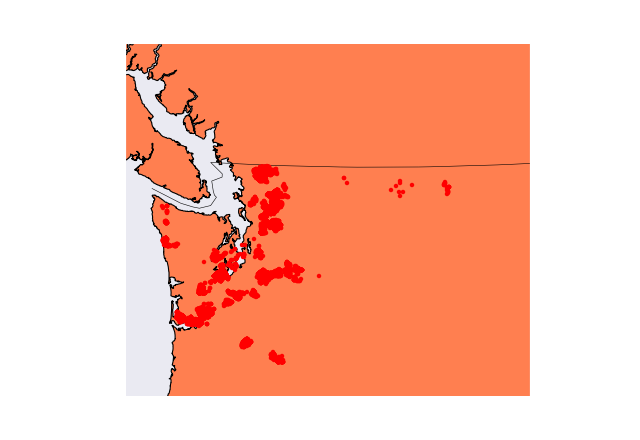

In [17]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
%matplotlib nbagg
my_map2 = Basemap(llcrnrlon=-125, llcrnrlat=45, urcrnrlon=-115, urcrnrlat=51, projection='tmerc', lat_1=33, lat_2=45,
     lon_0=-119, lat_0=45, resolution='h', area_thresh=10000)
my_map2.drawcoastlines()
my_map2.drawcountries()
my_map2.fillcontinents(color='coral')
lon2 = np.array(walandslides.POINT_X)
lat2 = np.array(walandslides.POINT_Y)
y2,x2 = my_map2(lon2, lat2)
my_map2.plot(y2,x2, 'ro', markersize=4, markeredgecolor = 'k')
plt.show()

## Final X and y - reduced to a size of 12241 observations

In [118]:
walandslides['LAND_USE'] = walandslides.LAND_USE.map({'Forestry related activities':0, 'Undisturbed':1, 'Unknown':2, 'Urban development':3, 'Road, railroad, trail':4})

In [119]:
X = walandslides[feature_cols]
y = walandslides.LANDSLID_3
y = pd.concat([y], axis=1)
X[:5]

,gradient_cat,GEOLOGIC_1,reacch_soi,LAND_USE,LANDSLIDE1,SLOPE_MORP
1,3,29787,55856,4,12,0
2,5,33552,55805,4,3,4
4,1,32784,55804,4,12,0
5,4,30800,55837,4,3,0
6,3,30800,55837,3,12,0


### Response Variable - LANDSLID_3 - Landslide severity (0=Low, 1=Med, 3=High)

In [120]:
landslid3_pd = y['LANDSLID_3'].value_counts()
y['LANDSLID_3'].value_counts()

2    7501
1    3806
0     934
dtype: int64

## run train test split

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

## Begin Model analysis

### Calculate Null Accuracy

In [93]:
import time
start = time.time()

nulltime1 = %%timeit -o 1 + 2
null = y_test['LANDSLID_3'].value_counts().head(1) / len(y_test['LANDSLID_3'])
print null

end = time.time()
nulltime1 = end - start
print nulltime1

The slowest run took 578.46 times longer than the fastest. This could mean that an intermediate result is being cached 
10000000 loops, best of 3: 29.7 ns per loop
2    0.613198
dtype: float64
1.91505408287


## 10-fold cross-validation with Bagged Random Forest


In [94]:
y = np.ravel(y)

In [95]:
import time
start = time.time()

rfreg = RandomForestClassifier(n_estimators=20, max_features=4, oob_score=True, random_state=1)
rfreg.fit(X, y)

bagrf = BaggingClassifier(rfreg, n_estimators=20, max_samples=10000, max_features=6, bootstrap = False, bootstrap_features = True, random_state=42)
bagrf.fit(X, y)
bagrf_scores_mean = cross_val_score(bagrf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

end = time.time()
bagrftime1 = end - start
print bagrftime1

110.357401848


In [96]:
print bagrf_scores_mean

0.768075363479


In [97]:
bagrf.predict_proba([1,2,1,1,100,1])[:, 1]

array([ 0.21532174])

In [98]:
import cPickle as pickle
pickle.dump(bagrf, open('/git/data/landslides/models/climate-landslide.pkl', 'wb'))

In [100]:
bagrf_loaded = pickle.load(open('/git/data/landslides/models/climate-landslide.pkl', 'rb'))

In [103]:
%run climate-landslides-routes.py

In [ ]:
url = "http://129.101.160.58:5000/api"
data = json.dumps({'cool':1, 'useful':8, 'funny':2})
r = requests.post(url, data)

print r.json()